# LP2 Classification Problem

### 1. Business Understanding
#### 1.1 Description 

In today's rapidly evolving telecommunications industry, service providers face intense competition, making the retention of existing customers a critical challenge. It is well-known that the cost of acquiring new customers outweighs that of retaining existing ones. To address this challenge, our project aims to develop a churn prediction model to forecast customer attrition and facilitate targeted retention strategies. 

#### 1.2 Objective  
The primary objective of this project is to create an efficient churn prediction model that can identify customers at risk of churning. By proactively identifying potential churners, the telecom company can take timely and personalized actions to retain valuable customers and prevent revenue loss.  

#### 1.3 Approach 
Our approach involves implementing machine learning techniques for churn prediction. We will explore and compare the performance of two popular algorithms: Logistic Regression, Decision Trees, Random Forest, and Support Vector Machines (SVM). 

  
### 2. Data understanding
There are 3 datasets used in this project. They all contain information about customers in a Telecom company. The following describes the columns present in the data.

* **Gender** -- Whether the customer is a male or a female

* **Partner** -- Whether the customer has a partner or not (Yes, No)

* **SeniorCitizen** -- Whether a customer is a senior citizen or not

* **Dependents** -- Whether the customer has dependents or not (Yes, No)

* **Tenure** -- Number of months the customer has stayed with the company

* **Phone Service** -- Whether the customer has a phone service or not (Yes, No)

* **InternetService** -- Customer's internet service provider (DSL, Fiber Optic, No)

* **MultipleLines** -- Whether the customer has multiple lines or not

* **OnlineSecurity** -- Whether the customer has online security or not (Yes, No, No Internet)

* **OnlineBackup** -- Whether the customer has online backup or not (Yes, No, No Internet)

* **DeviceProtection** -- Whether the customer has device protection or not (Yes, No, No internet service)

* **TechSupport** -- Whether the customer has tech support or not (Yes, No, No internet)

* **StreamingTV** -- Whether the customer has streaming TV or not (Yes, No, No internet service)

* **StreamingMovies** -- Whether the customer has streaming movies or not (Yes, No, No Internet service)

* **Contract** -- The contract term of the customer (Month-to-Month, One year, Two year)

* **PaperlessBilling** -- Whether the customer has paperless billing or not (Yes, No)

* **Payment Method** -- The customer's payment method (Electronic check, mailed check, Bank transfer(automatic), Credit card(automatic))

* **MonthlyCharges** -- The amount charged to the customer monthly

* **TotalCharges** -- The total amount charged to the customer

* **Churn** -- Whether the customer churned or not (Yes or No)


<br>

#### **Installing and importing libraries**


In [1]:
# %pip install pyodbc  
# %pip install python-dotenv
# %pip install imbalanced-learn
# %pip install seaborn


In [2]:
# pip install scikit-learn==1.2.2

In [121]:
import pyodbc
from dotenv import dotenv_values 

# Analysis libraries
import pandas as pd 
import numpy as np
from sklearn.impute import SimpleImputer
import re
import datetime
from datetime import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor


#Machine learning libraries
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.metrics import ConfusionMatrixDisplay,accuracy_score, recall_score, precision_score, f1_score,roc_auc_score,roc_curve#,plot_confusion_matrix
from sklearn.feature_selection import RFE, RFECV
from imblearn.over_sampling import SMOTE
from sklearn.base import clone
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics,svm
from xgboost import XGBClassifier



# Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Warning libraries
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, Markdown
from prettytable import PrettyTable

#### **Loading data**

In [4]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')


# Get the values for the credentials you set in the '.env' file
database = environment_variables.get("DATABASE")
server = environment_variables.get("SERVER")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")


connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [5]:
# Use the connect method of the pyodbc library and pass in the connection string.
# This will connect to the server and might take a few seconds to be complete. 
# Check your internet connection if it takes more time than necessary

connection = pyodbc.connect(connection_string)

In [6]:
# Now the sql query to get the data is what what you see below. 
# Note that you will not have permissions to insert delete or update this database table. 

query = "Select * from dbo.LP2_Telco_churn_first_3000"
df1 = pd.read_sql(query, connection)
df1.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [7]:
df2=pd.read_csv("data/LP2_Telco-churn-last-2000.csv.")
df2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [8]:
#Checking if columns are same before concatination
print(f'dataset_1: {df1.columns}\n\n\
        dataset_2: {df2.columns}')

dataset_1: Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

        dataset_2: Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


In [9]:
# Concatenate the DataFrames to get one data set for the work
data=pd.concat([df1,df2])
data.sample(20)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
782,4871-JTKJF,Female,1,No,No,1,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,69.650000,69.65,Yes
498,1976-CFOCS,Female,1,Yes,No,1,Yes,No,DSL,No,...,No,No,No,No,Month-to-month,No,Electronic check,46.000000,46,Yes
2134,8974-OVACP,Female,0,False,False,1,True,False,No,None,...,None,None,None,None,Month-to-month,False,Mailed check,20.150000,20.15,False
1773,2007-QVGAW,Female,0,True,True,68,True,False,No,None,...,None,None,None,None,Two year,True,Bank transfer (automatic),19.350000,1292.65,False
2360,7064-JHXCE,Male,0,True,True,62,True,False,No,None,...,None,None,None,None,Two year,False,Credit card (automatic),20.049999,1263.9,False
2813,6484-LATFU,Male,0,False,False,68,True,True,No,None,...,None,None,None,None,Two year,False,Mailed check,24.549999,1657.4,False
290,0774-RMNUW,Female,0,Yes,Yes,71,No,No phone service,DSL,Yes,...,No,Yes,Yes,Yes,Two year,No,Bank transfer (automatic),59.700000,4122.65,No
737,7989-VCQOH,Male,0,Yes,Yes,18,Yes,No,DSL,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,No,Electronic check,83.250000,1611.15,No
1377,7851-FLGGQ,Male,0,No,No,1,No,No phone service,DSL,No,...,No,Yes,No,Yes,Month-to-month,Yes,Mailed check,44.650000,44.65,Yes
1014,4695-VADHF,Male,0,True,True,18,True,False,DSL,False,...,True,False,False,True,Month-to-month,False,Electronic check,57.450001,990.85,True


#### **Previewing the dataset**

In [10]:
#Preview the data
print(data.shape,"\n")
print(data.info())

(5043, 21) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   int64  
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-nu

**From the summary above:**
* All columns are string except for ```SeniorCitizen``` ,```tenure ``` and  ```MonthlyCharges```
* There are missing values in several columns.

**From thoroughly examining the dataset, we came out with the following analytical questions:**

* What is the correlation between phone service and churn?
* Do charges contribute to customer churn?
* What is the average tenure of customers?
* How is customer churn aligned with whether a customer has a partner and dependents or not?
* Does being a senor citizen contribute significantly to churn?
* Is customer retention heavily dependent on customer's access to tech support?
* What effect does the online security have on tenure?
* What factors/variables significantly contribute to customer churn?

**Hypothesis Testing**

Hypothesis 1<br>
_**Null:**_ Total charges do not contribute to churn rate among customers.<br>
_**Alternate:**_ Total charges significantly contribute to churn rate among customers.

Hypothesis 2 <br>
_**Null:**_ Customer churn rate does not depend on multiple services subscription.<br>
_**Alternate:**_ Customer churn rate significantly depend on multiple services subscription.




In [11]:
#Getting unique values for each column
for col in data.columns:
    print(f"Unique values of {col} are {data[col].unique()}\n")

Unique values of customerID are ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

Unique values of gender are ['Female' 'Male']

Unique values of SeniorCitizen are [0 1]

Unique values of Partner are [True False 'No' 'Yes']

Unique values of Dependents are [False True 'No' 'Yes']

Unique values of tenure are [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]

Unique values of PhoneService are [False True 'Yes' 'No']

Unique values of MultipleLines are [None False True 'No' 'No phone service' 'Yes']

Unique values of InternetService are ['DSL' 'Fiber optic' 'No']

Unique values of OnlineSecurity are [False True None 'No' 'Yes' 'No internet service']

Unique values of OnlineBackup are [True False None 'No' 'Yes' 'No internet service']

Unique values of DeviceProtection are [False Tr

**Issues arising :**
* Most columns have two values which mean the same thing eg. In ```Partner``` there are values like 'False' and 'No' which mean the same thing.
*  For columns ```MonthlyCharges``` and ```TotalCharges``` , the values should be in a standard decimal place
*  The ```TotalCharges``` column should be converted to float datatype.

### 3. Data preparation

#### 3.1 Data cleaning

**Dealing with duplicates**

In [12]:
data.duplicated().value_counts()

False    5043
dtype: int64

The data contains no duplicates.<br> 

**Data uniformity**

* The ```TotalCharges``` and ```MonthlyCharges``` columns have different decimal places so we are going to standardize the columns to 2 dp. 
* But first of all, the ```TotalCharges``` column needs to be converted to a numeric data type as it is in string format.




In [13]:
#Converting to numric data type
data["TotalCharges"]=pd.to_numeric(data["TotalCharges"],errors="coerce")
data["TotalCharges"].dtype

dtype('float64')

In [14]:
#Formatting to 2 decimal places
data["MonthlyCharges"]= data["MonthlyCharges"].round(2)
data["TotalCharges"] = data["TotalCharges"].round(2)
data[["MonthlyCharges","TotalCharges"]].sample(4)


,MonthlyCharges,TotalCharges
1412,84.30,1308.40
2684,105.20,7386.05
1517,100.55,5514.95
174,20.55,654.55


**Cleaning the categorical columns**

In [15]:
# Function to convert 'Yes'/'No' values to booleans


def convert_to_boolean(df, column):

    def convert_value(value): 

        if value == True:
            return "Yes"

        elif value == False:
            return "No"

        else:
            return value

    df[column] = df[column].apply(convert_value)

    return df



In [16]:

# Create a list of categorical variables by excluding numerical columns
cat_variables = data.drop(['customerID','tenure','TotalCharges','MonthlyCharges'], axis=1)
cat_variables

# Invoke function to convet for all columns in data
for col in cat_variables:
    data = convert_to_boolean(data, col)

In [17]:
# Validate

#Getting unique values for each column
for col in data.columns:
    print(f"Unique values of {col} are {data[col].unique()}\n")

Unique values of customerID are ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

Unique values of gender are ['Female' 'Male']

Unique values of SeniorCitizen are ['No' 'Yes']

Unique values of Partner are ['Yes' 'No']

Unique values of Dependents are ['No' 'Yes']

Unique values of tenure are [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]

Unique values of PhoneService are ['No' 'Yes']

Unique values of MultipleLines are [None 'No' 'Yes' 'No phone service']

Unique values of InternetService are ['DSL' 'Fiber optic' 'No']

Unique values of OnlineSecurity are ['No' 'Yes' None 'No internet service']

Unique values of OnlineBackup are ['Yes' 'No' None 'No internet service']

Unique values of DeviceProtection are ['No' 'Yes' None 'No internet service']

Unique values of TechSuppor

**Cleaning the tenure column**
- It was noticed that there are values with 0 from the ```Tenure ``` column, upon closer inspection the same rows have ```Churn``` as False and ```Totalcharges``` were missing since totalcharges is a product of tenure and monthlycharges. However, its rather odd that if the customers did not stay with the company for more than a month , they should have churned but that is not the case therefore, we will delete these rows.

In [18]:
# Inspecting the `tenure` column
data[data["tenure"] == 0]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,No,Yes,Yes,0,No,None,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,No,No,Yes,0,Yes,No,No,None,...,None,None,None,None,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,No,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,No,Yes,Yes,0,Yes,Yes,No,None,...,None,None,None,None,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,No,Yes,Yes,0,No,None,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
218,2923-ARZLG,Male,No,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
1670,4075-WKNIU,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No
1754,2775-SEFEE,Male,No,No,Yes,0,Yes,Yes,DSL,Yes,...,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,NaN,No


In [19]:
#Dropping the rows
data.drop(labels=data[data["tenure"] == 0].index,axis= 0,inplace= True)

In [20]:
#Confirming
data[data["tenure"] == 0]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


**Handling missing values**

In [21]:
#Checking missing values
data.isnull().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       267
InternetService       0
OnlineSecurity      649
OnlineBackup        649
DeviceProtection    649
TechSupport         649
StreamingTV         649
StreamingMovies     649
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          0
Churn                 1
dtype: int64


**Decison mades:**

* Given that ```OnlineSecurity```, ```OnlineBackup``` ,```DeviceProtection```  ,```TechSupport```, ```StreamingTV```,```StreamingMovies``` and ```Mutliple lines``` are categorical columns, instead of dropping the columns or imputing with the mode , we are going to replace them with False. This is because in the real world , if someone doesn't fill an entry for a 'No' or 'Yes' question chances are very high they don't have the particular thing. This is an assumption but one that makes sense.<br>

* For the missing ```Churn``` value ,it will be dropped.

In [22]:

# fill the null categorical values with 'False'
data['OnlineSecurity'] = data['OnlineSecurity'].fillna('No')
data['OnlineBackup'] = data['OnlineBackup'].fillna('No')
data['DeviceProtection'] = data['DeviceProtection'].fillna('No')
data['TechSupport'] = data['TechSupport'].fillna('No')
data['StreamingTV'] = data['StreamingTV'].fillna('No')
data['StreamingMovies'] = data['StreamingMovies'].fillna('No')
data['MultipleLines'] = data['MultipleLines'].fillna('No')


#Dropping the missing value row 
data=data.dropna(axis=0,subset=["Churn"])




In [23]:
#Confirming if missing values are still there
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [24]:
data.columns = data.columns.str.lower() #convert all columns to lower case
data.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

In [25]:
# Save the bridged data as csv file
data.to_csv('data/complete.csv',index=False)

**Inspecting outliers by Visualization**

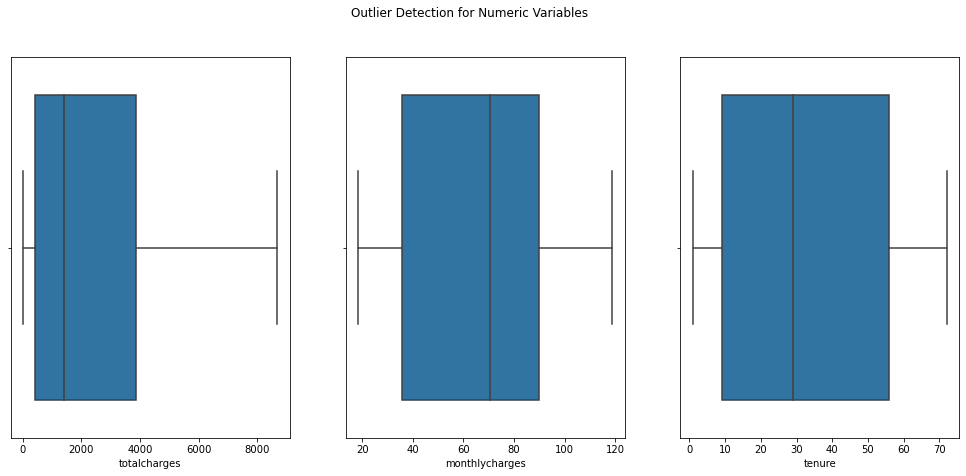

In [26]:
#Plotting box plot to visualize outliers
numerical_col=["monthlycharges","totalcharges", "tenure"]
fig,axes= plt.subplots(ncols=3,nrows=1,figsize=(17,7))

sns.boxplot(x=data['totalcharges'],ax=axes[0])
sns.boxplot(x=data['monthlycharges'],ax=axes[1])
sns.boxplot(x=data['tenure'],ax=axes[2])
title =fig.suptitle('Outlier Detection for Numeric Variables')

plt.show()

**Observations from outlier analysis.**

*  Our numerical columns are within range ,as no outliers can be seen.  

*  However, `TotalCharges` and `MonthlyCharges` are positively and negatively skewed respectively. 
* `TotalCharges` exhibits a tail that extends towards larger values (4000). Its mean, therefore is greater than the median, which is also greater than the mode.<br>
*  On the other hand, `MonthlyCharges` extends its tail towards the smaller values (40). This indicates a lesser mean than the median, which is also less than the mode

*  The `tenure` column has a near normal distribution.

#### 3.2 Exploratory Data Analysis (EDA).

*  EDA is an essential and crucial initial step in the data analysis process, where the main objective is to gain insights and understanding of the dataset before performing any formal statistical modeling or making inferences.<br> 

* A variety of techniques to summarize, visualize, and interpret crucial characteristics and patterns present in the data are implemented in EDA. 

* EDA encompasses three components: `Univariate`, `Bivariate` and `Multivariate` analysis.

##### 3.2.1. Univariate Analysis
*  Here, we critically examin each variable as a separate entity in terms of statistical distributions.


**EDA of Numeric Variables**

In [27]:
numerical_col  # Get the numerical columns

['monthlycharges', 'totalcharges', 'tenure']

In [28]:
data[numerical_col].describe()

,monthlycharges,totalcharges,tenure
count,5026.000000,5026.000000,5026.000000
mean,65.102407,2299.938778,32.613808
std,30.064849,2268.113979,24.510960
min,18.400000,18.800000,1.000000
25%,35.800000,417.662500,9.000000
50%,70.575000,1400.700000,29.000000
75%,90.050000,3857.012500,56.000000
max,118.650000,8670.100000,72.000000


`MonthlyCharges`

*With the assumption that the monetary figures are quoted in usd,* 

* The `mean` monthly charge is `65usd`.
* The `least` monthly charge is `18usd`.
* `Median` monthly charge is `71usd`
* `Highest` amount charged per month is `119usd`.


`TotalCharges`

* The `mean` total charge is `2301usd`.
* The `least` total charge is `19usd`.
* `Median` total charge is `1401usd`
* `Highest` amount charged per month is `8670usd`.


`tenure`

* The `mean` tenure is `33 months`.
* The `least` recoreded `0 months`.
* `Median` is `29 months`
* `Highest` amount per month is `72 months`.

**Frequency Distributions of Numerical Variables**

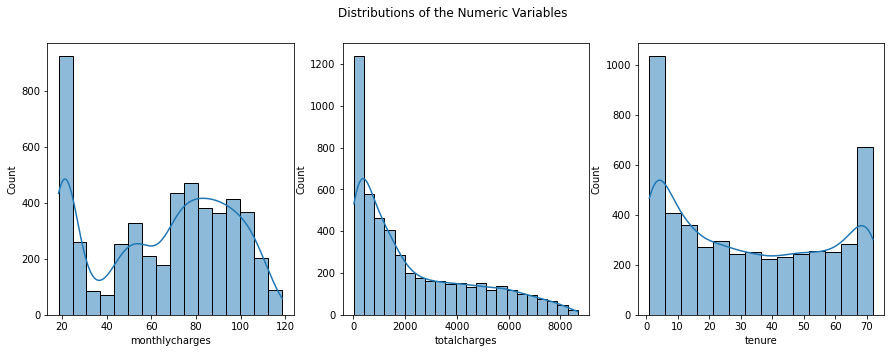

In [29]:

fig, axes = plt.subplots(1, 3, figsize=(15, 5)) # Create a figure and three subplots
sns.histplot(data=data['monthlycharges'], kde="Yes", ax=axes[0])  # Plot first figure axes[0]
sns.histplot(data=data['tenure'],kde=True, ax=axes[2])          # Plot third figure axes[2]
sns.histplot(data=data['totalcharges'], kde="Yes", ax=axes[1])    # Plot second figure axes[1]
title = fig.suptitle('Distributions of the Numeric Variables');         # Give general title

**Summary**<br>
`MonthlyCharges`
* The highest(near `1000`) number of customers have very low monthly charges from about `18` usd to `25` usd.
* The middle class was charged between `50` to `100` usd.
* The top users incured above `100` usd.



`TotalCharges`

* Majority of customers have total charges below `2000` usd.
* The middle class was charged between `2000` to `6000` usd in total.
* The top users incured above `6000` usd as their total charges.


`tenure`

* Most customers have tunure of `5` months and less and above `65` months.
* On average, customers' tenure is about `35` months.

**EDA of Categorical Variables**

In [30]:
# Create a list of categorical variables by excluding numerical columns
data = data.drop('customerid', axis=1)
categorical_variables = data.columns[~data.columns.isin(numerical_col)].tolist()
categorical_variables

['gender',
 'seniorcitizen',
 'partner',
 'dependents',
 'phoneservice',
 'multiplelines',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'contract',
 'paperlessbilling',
 'paymentmethod',
 'churn']

Get the statistical summary about the categorical variables

In [31]:
# Get the statistical distribution

data[categorical_variables].describe()

,gender,seniorcitizen,partner,dependents,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,churn
count,5026,5026,5026,5026,5026,5026,5026,5026,5026,5026,5026,5026,5026,5026,5026,5026,5026
unique,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,Male,No,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,2548,4209,2579,3476,4539,2684,2244,3150,2877,2865,3116,2665,2623,2740,2985,1698,3692


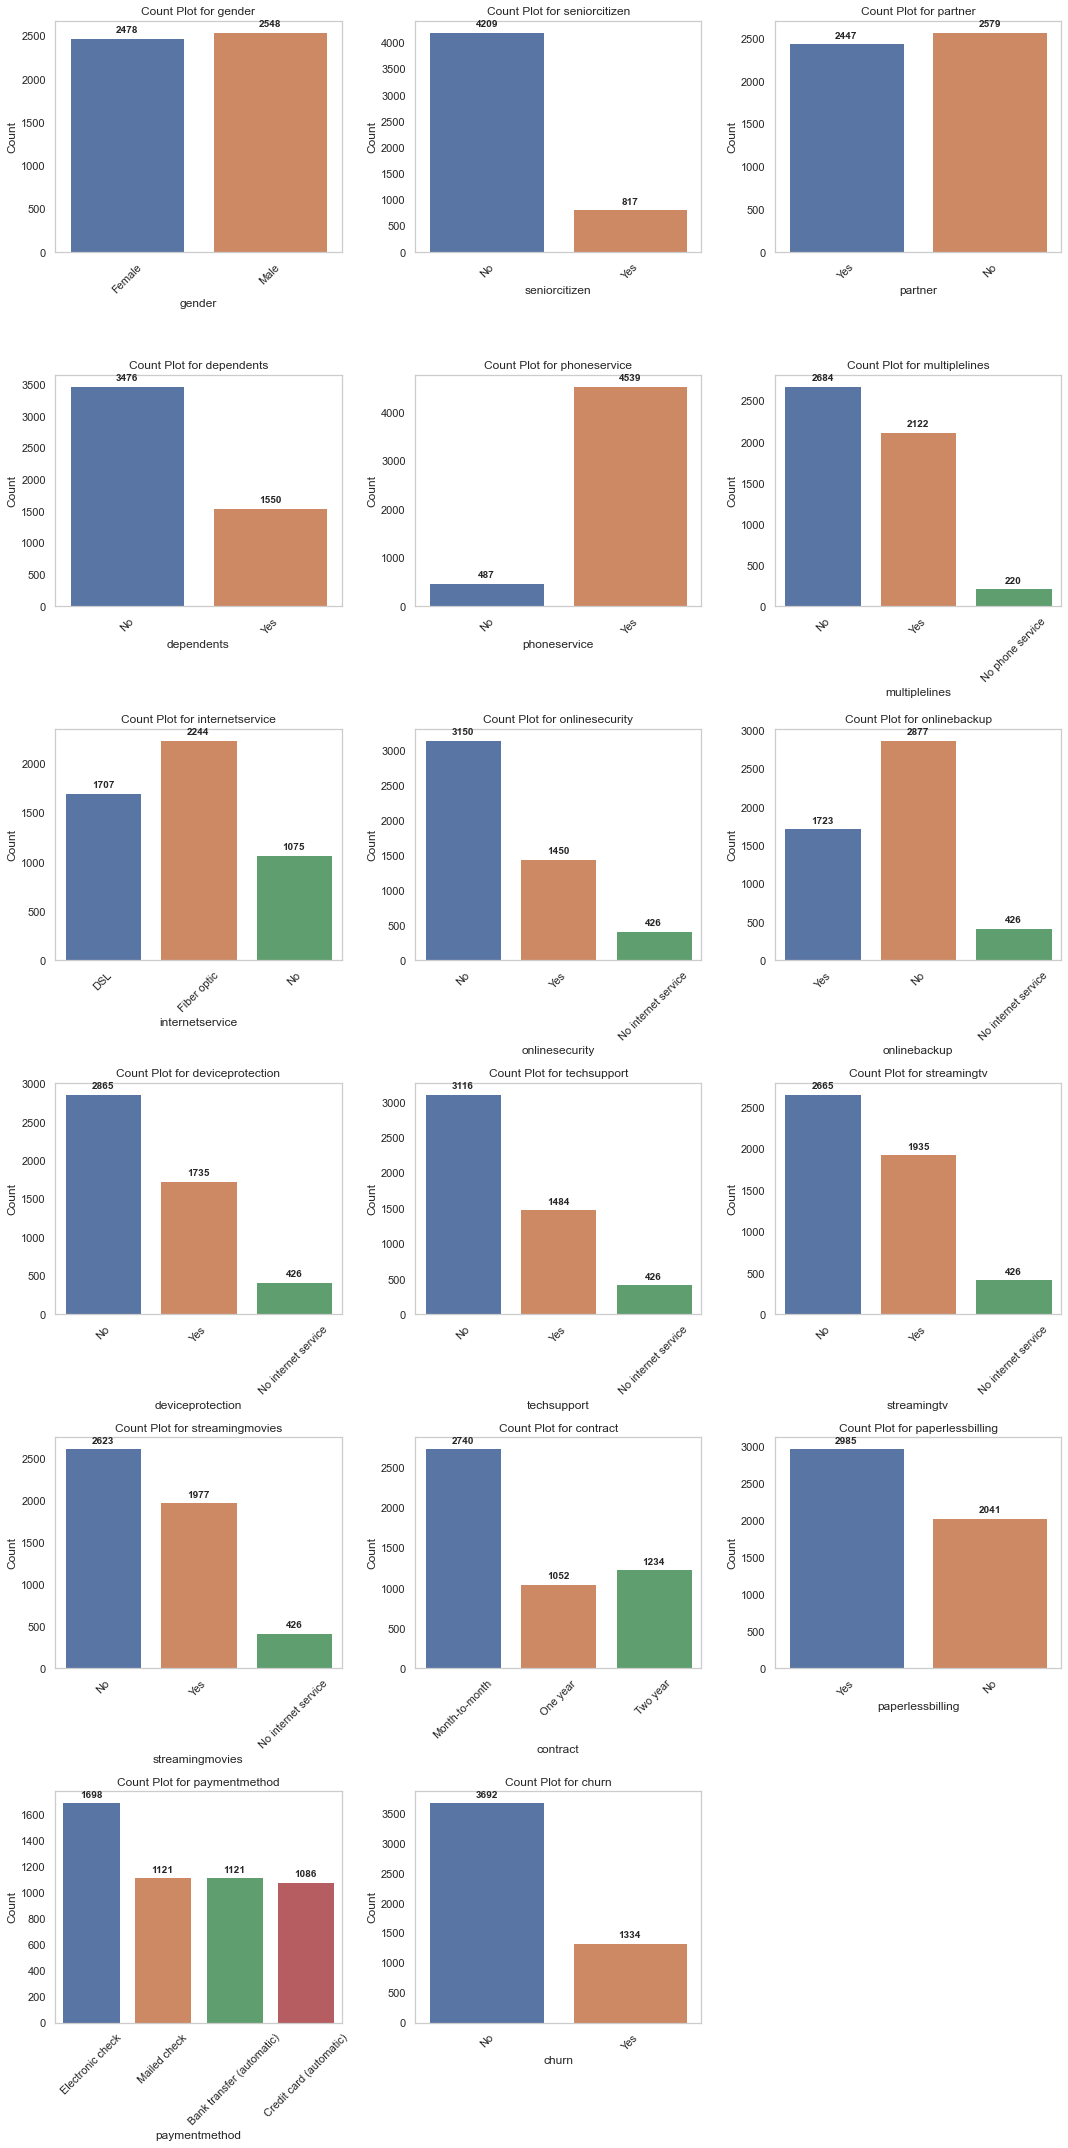

In [32]:
# Calculate the number of rows and columns for subplots
num_cols = 3
num_rows = (len(categorical_variables) - 1) // num_cols + 1

# Plot count plots for all categorical columns
sns.set(style="whitegrid")
plt.figure(figsize=(5 * num_cols, 5 * num_rows))

for i, col in enumerate(categorical_variables):
    plt.subplot(num_rows, num_cols, i + 1)
    ax = sns.countplot(x=col, data=data[categorical_variables])
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.title(f"Count Plot for {col}")
    plt.xticks(rotation=45)

    # Add count values above each bar
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}', xy=(p.get_x() + p.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
    plt.grid(False)

plt.tight_layout()  # To improve subplot spacing
plt.show()

**Summary on Observations :**

`Gender`<br>
For this data, gender refers to whether male or female.
There are more males than females. They account for `51% `of customers.

`Seniorcitizen`<br>
Majority of customers are not senior citizens. Out of the 5042 customers, only `819` are 60 or 65 years old and maybe are pensioners.

`Partner`<br>
Customers without partner exceed those with partner with just `128`.

`Dependents`<br>
This variable refers to whether a customer has dependents or not. From the visualization, `3481` customers have no dependents.

`Phoneservice`<br>
For whether or not a customer had subscribed to phone service, `4553`, representing 90% did subscribe.


`Multiplelines`<br>
Among the three unique options to this variable, without multiple lines outweighs the rest. `2693`customers did not have multiple lines.

`Internetservice`<br>
The internet service variable pertains to whether a customer opted for DSL, fiber optic or none. From the statistical summary, `2247`customers subscribed to fiber optic. 

`Onlinesecurity`<br>
More customers (`3158`) did not adopt the online security service.

`Onlinebackup`<BR>
Out of the 5042 customers, `2882` did not subscribe to online backup.

**Examining the Target Variable**

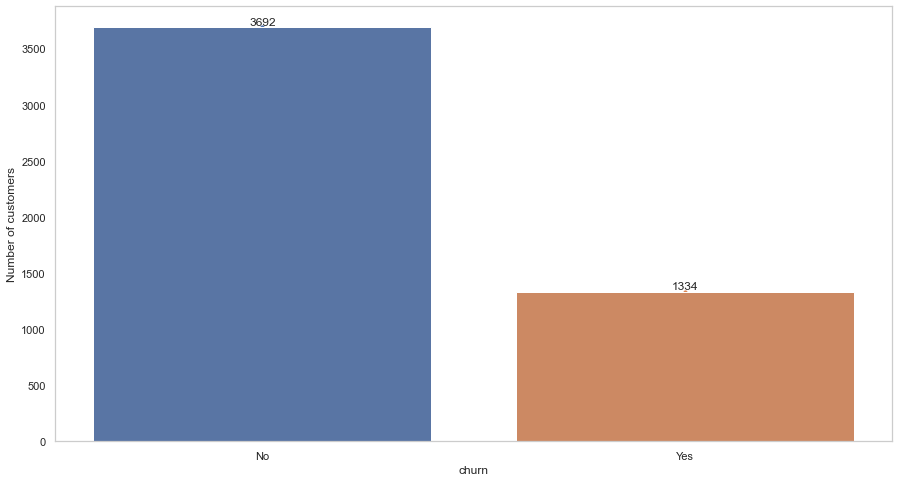

In [33]:
churn_rate=data["churn"].value_counts()
plt.figure(figsize=(15,8))
sns.countplot(x=data["churn"])
plt.ylabel("Number of customers")
for index, value in enumerate(churn_rate):
    plt.scatter(index, value, s=10)  # s=100 for marker size
    plt.annotate(str(value), xy=(index, value), xytext=(index, value+1),
                 ha='center', va='bottom', fontsize=12)

# Remove the grid lines
plt.grid(False)



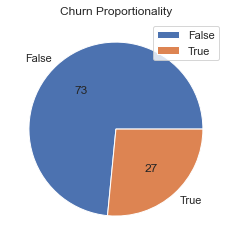

In [34]:
plt.pie(data.churn.value_counts(),
        labels= ['False', 'True'],
        autopct='%.f', normalize=True)
plt.title('Churn Proportionality')
plt.legend()
plt.show()

 **Conclusion on the Churn rate**
* There are 3692 customers that remained in the company which is 73% of the customers while 1334 (27% of the customers)  churned meaning the retention rate is higher than the churn rate.
* There is also a class imbalance in the target variable as there is unequal distribution of classes in the dataset. This issue will later be addressed as the machine learning classifier tends to be more biased towards the majority class, causing bad classification of the minority class

##### 3.2.2 Bivariate analysis

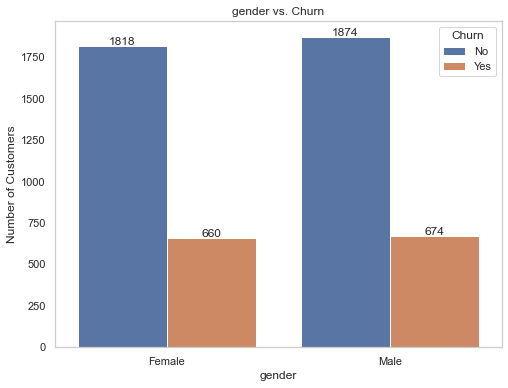

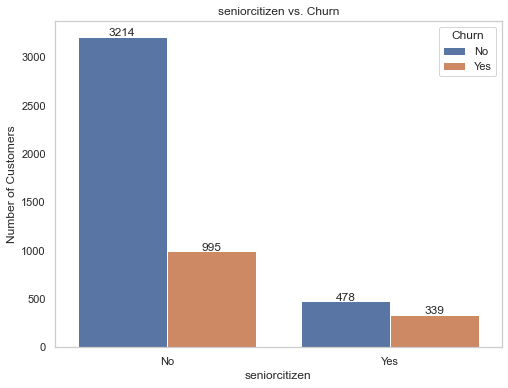

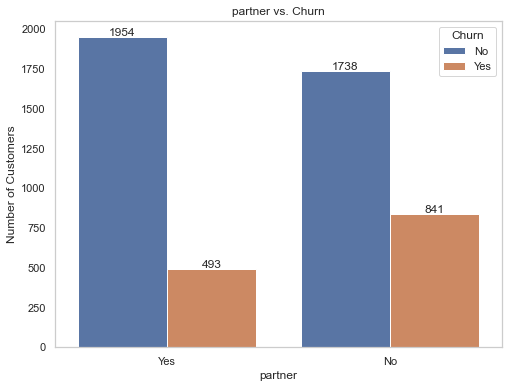

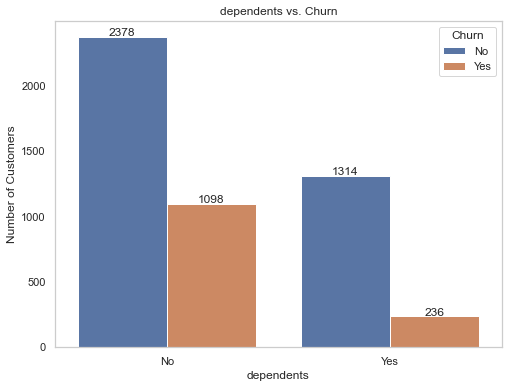

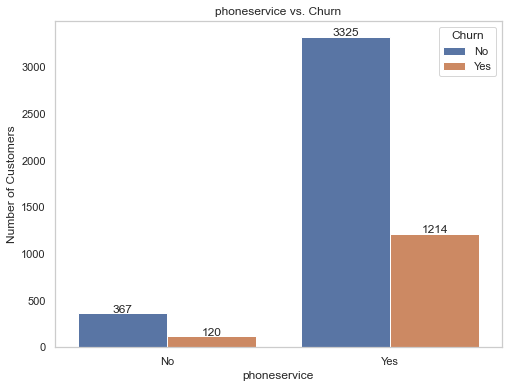

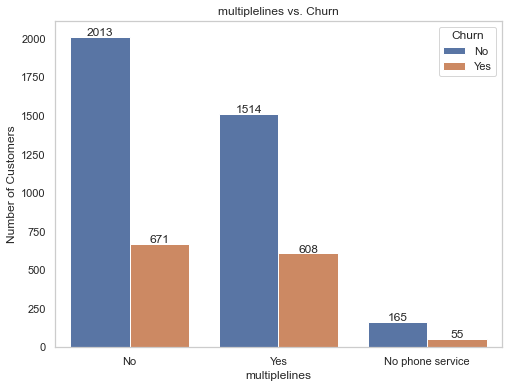

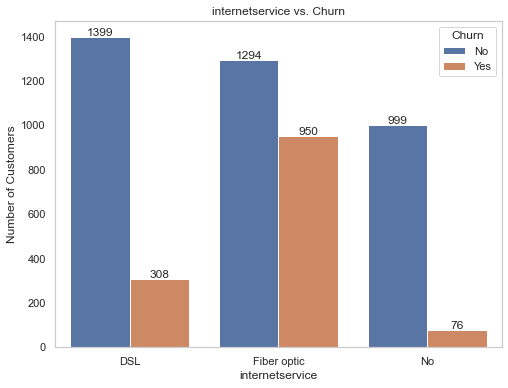

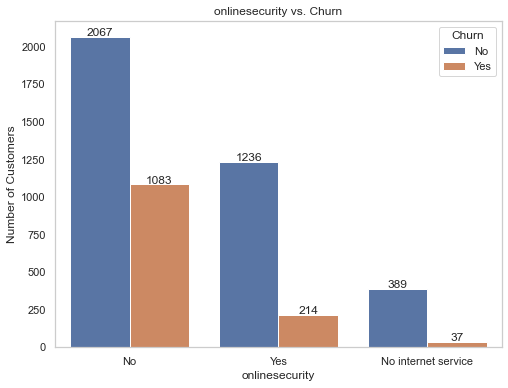

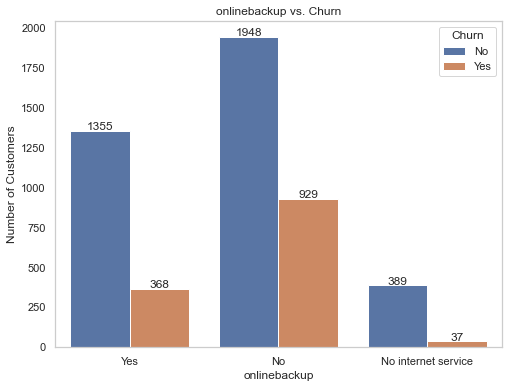

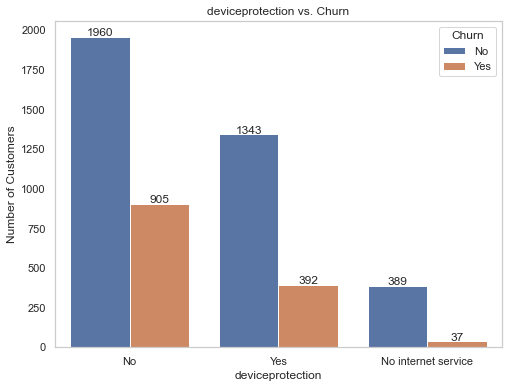

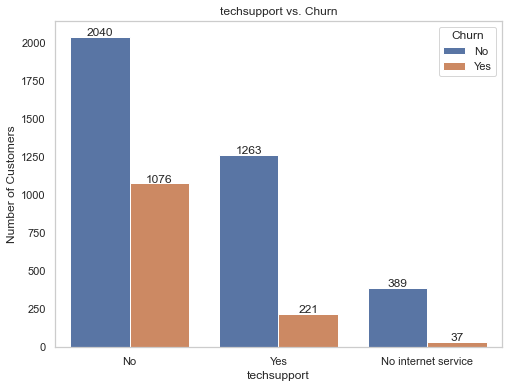

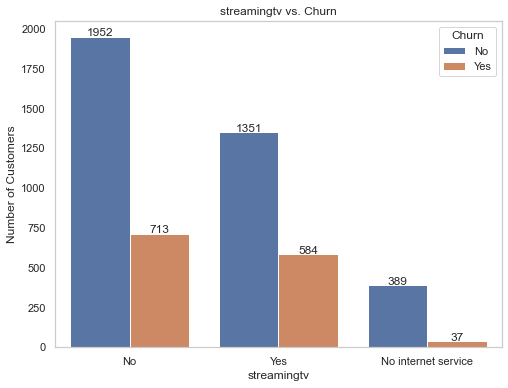

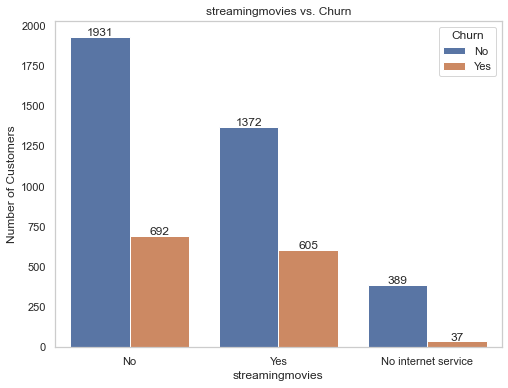

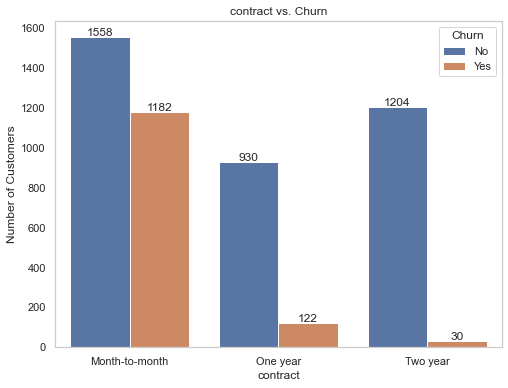

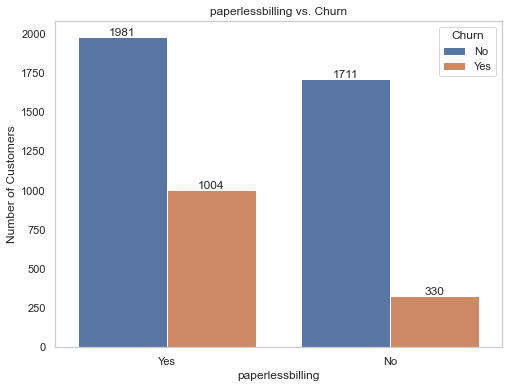

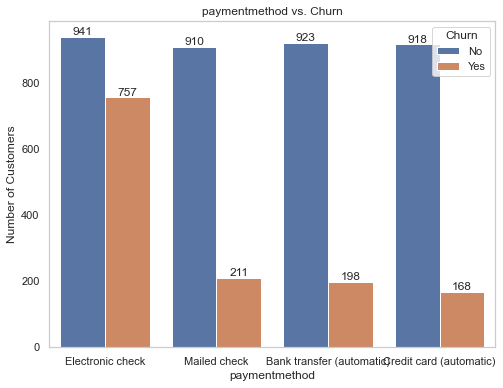

In [35]:


visualization_categorical_variables = ['gender', 'seniorcitizen', 'partner', 'dependents', 'phoneservice',
                         'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup',
                         'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies',
                         'contract', 'paperlessbilling', 'paymentmethod']
for var in visualization_categorical_variables:
    plt.figure(figsize=(8, 6))
    ax=sns.countplot(x=var, hue='churn', data=data)
    plt.xlabel(var)
    plt.ylabel('Number of Customers')
    plt.title(f'{var} vs. Churn')
    plt.legend(title='Churn', loc='upper right')

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2, height + 5, f'{height}', ha='center')

    plt.grid(False)
    plt.show()

 


**Summary of Visualizations**

* Males are likely to leave the company more than females. The males are also likely to stay in the company more than females.

*  More senior citizens are likely to stay in a company than quit.

*  Those with partners are more likely to stay in a company as opposed to those without partners who are more likely to quit a company.

*  Those without dependents are more likely to quit the company unlike those with dependents.

* Phone service affects greatly if a customer will churn or not.

* Customers that use multiple lines are likely to stay in a company as opposed to others.

* Most customers that stayed in the company are those that used DSL internet service.
* Most customers that don't use online security are likely to stay in the company.
* Usage of online backup doesn't make a customer stay since most customers that stayed did not utilize the online backup services.
* Technical support can make a customer stay or leave since those that didn't use technical support were the highest contributor to a customer leaving or staying.
* A contract period contributes to churn rate. The shorter the contract term, the higher the rate of churn.
* Paperless billing is a major contributor to a customer not churning. Those that use paperless billing are more likely to stay.
* Most customers that left are those that used electronic check as the method of paying.


### 3.3. Data preprocessing.

Data preprocessing is an integral step in Machine Learning as the quality of data and the useful information that can be derived from it directly affects the ability of our model to learn; therefore, it is extremely important that we preprocess our data before feeding it into our model.It shall involve te following steps:

1. Splitting data into train and test
2. One-hot encoding categorical data
3. Dealing with multicollinearity
4. Dealing with class imbalance in the target variable
5. Dimensionality reduction
6. Scaling the data

In [36]:
data.sample(4)  #Get 4 samples of the data

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
1069,Male,No,Yes,Yes,59,Yes,No,DSL,No,Yes,Yes,Yes,Yes,Yes,One year,No,Credit card (automatic),76.75,4541.90,No
115,Male,No,Yes,No,46,Yes,No,DSL,Yes,Yes,Yes,Yes,No,No,Two year,No,Mailed check,65.65,3047.15,No
775,Male,No,Yes,Yes,58,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Two year,No,Bank transfer (automatic),82.50,4828.05,No
1176,Male,No,No,No,43,Yes,Yes,Fiber optic,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,77.85,3365.85,Yes


##### **Splitting the data to train and test**

Splitting the dataset into train and test sets is one of the important parts of data pre-processing, as by doing so, we can improve the performance of our model and hence give better predictability. Also it helps avoid overfitting

In [37]:
# partion features and target 
X=data.drop("churn",axis=1)
y= data["churn"]

# train test split
X_train, X_test, y_train, y_test= train_test_split(X, y,test_size=0.2, random_state =42)

In [38]:
#Previewing the shape of dataset(splits)
print(f"The shape for X_train is {X_train.shape}")
print(f"The shape for X_test is {X_test.shape}")
print(f"The shape for y_train is {y_train.shape}")
print(f"The shape for y_test is {y_test.shape}")

The shape for X_train is (4020, 19)
The shape for X_test is (1006, 19)
The shape for y_train is (4020,)
The shape for y_test is (1006,)


##### **One Hot Encoding and Binary Encoding**

In [39]:
# check unique values before encoding

for category in categorical_variables:
    print(f"The unique values for {category} are {data[category].unique()}\n")

The unique values for gender are ['Female' 'Male']

The unique values for seniorcitizen are ['No' 'Yes']

The unique values for partner are ['Yes' 'No']

The unique values for dependents are ['No' 'Yes']

The unique values for phoneservice are ['No' 'Yes']

The unique values for multiplelines are ['No' 'Yes' 'No phone service']

The unique values for internetservice are ['DSL' 'Fiber optic' 'No']

The unique values for onlinesecurity are ['No' 'Yes' 'No internet service']

The unique values for onlinebackup are ['Yes' 'No' 'No internet service']

The unique values for deviceprotection are ['No' 'Yes' 'No internet service']

The unique values for techsupport are ['No' 'Yes' 'No internet service']

The unique values for streamingtv are ['No' 'Yes' 'No internet service']

The unique values for streamingmovies are ['No' 'Yes' 'No internet service']

The unique values for contract are ['Month-to-month' 'One year' 'Two year']

The unique values for paperlessbilling are ['Yes' 'No']

The uniq

In [40]:
#Binary encoding for columns with two values
binary_columns=['seniorcitizen', 'partner', 'dependents','phoneservice']  # Subset variables with only two unique values-yes/no
for col in binary_columns:
    X_train[col]=X_train[col].apply(lambda x: 1 if x in ['Yes'] else 0)   # Encode yes to 1, no to 0
X_train.sample(5)  # Get 5 samples of the output dataframe

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges
1460,Male,0,0,0,5,1,Yes,Fiber optic,No,Yes,Yes,No,No,No,Month-to-month,Yes,Electronic check,85.30,424.15
854,Female,0,0,0,68,1,No,No,No,No,No,No,No,No,Two year,No,Credit card (automatic),20.50,1424.90
1013,Female,0,0,0,1,1,No,DSL,No,Yes,No,No,No,No,Month-to-month,No,Electronic check,49.50,49.50
1376,Male,0,0,0,5,1,No,DSL,No,No,Yes,No,Yes,Yes,One year,Yes,Mailed check,70.00,347.40
847,Female,0,1,1,12,0,No,DSL,Yes,No,No,Yes,No,No,One year,No,Credit card (automatic),33.15,444.75


In [41]:
#Binary encoding for gender column
X_train['gender']=X_train['gender'].apply(lambda x: 1 if x in ['Male'] else 0)
X_train.sample(5)

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges
2266,1,1,1,0,52,1,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),104.45,5481.25
127,1,0,1,0,72,1,Yes,No,No,No,No,No,No,No,Two year,Yes,Bank transfer (automatic),23.55,1723.95
1987,0,0,1,1,25,1,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),89.15,2257.75
1573,1,0,1,1,47,1,No,Fiber optic,Yes,Yes,Yes,No,No,Yes,One year,Yes,Electronic check,96.10,4391.45
1759,1,0,0,0,20,1,No,No,No,No,No,No,No,No,Month-to-month,No,Mailed check,19.40,415.40


**One hot encoding for more than two values of categorical variable**

In [42]:
'''# index out the column with the object datatype
X_train_categorical = X_train.select_dtypes('object')

# instantiate the one hot encoder
ohe = OneHotEncoder(drop='first',sparse=False)


# fit and tranform the X_train dataset on the onehotencoder
dummies_train = ohe.fit_transform(X_train_categorical)

# create a dataframe from the encoded columns
X_train_encoded = pd.DataFrame(dummies_train, columns=ohe.get_feature_names_out(), index=X_train_categorical.index)
X_train = X_train.join(X_train_encoded)
X_train.head(5)'''

"# index out the column with the object datatype\nX_train_categorical = X_train.select_dtypes('object')\n\n# instantiate the one hot encoder\nohe = OneHotEncoder(drop='first',sparse=False)\n\n\n# fit and tranform the X_train dataset on the onehotencoder\ndummies_train = ohe.fit_transform(X_train_categorical)\n\n# create a dataframe from the encoded columns\nX_train_encoded = pd.DataFrame(dummies_train, columns=ohe.get_feature_names_out(), index=X_train_categorical.index)\nX_train = X_train.join(X_train_encoded)\nX_train.head(5)"

In [43]:
non_binary_columns=['multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod']

In [44]:
#One hot encode categorical data
for col in non_binary_columns:
    dummies=pd.get_dummies(X_train[col],prefix=col,drop_first=True)
    X_train=X_train.drop(col,axis=1)
    X_train=pd.concat([X_train,dummies],axis=1)
X_train.head(5)


,gender,seniorcitizen,partner,dependents,tenure,phoneservice,monthlycharges,totalcharges,multiplelines_No phone service,multiplelines_Yes,...,streamingtv_No internet service,streamingtv_Yes,streamingmovies_No internet service,streamingmovies_Yes,contract_One year,contract_Two year,paperlessbilling_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
989,1,1,1,0,3,1,94.60,279.55,0,1,...,0,1,0,1,0,0,1,0,1,0
150,0,0,1,1,8,1,68.55,564.35,0,0,...,0,1,0,1,0,0,1,0,1,0
1457,1,0,1,0,42,1,108.30,4586.15,0,1,...,0,1,0,1,1,0,1,0,1,0
1445,1,0,0,0,4,1,90.65,367.95,0,1,...,0,1,0,0,0,0,0,0,1,0
1434,1,0,0,0,1,1,50.50,50.50,0,0,...,0,0,0,0,0,0,1,0,1,0


**Binary Classification for the Train Target(Churn)**

In [45]:
y_train=y_train.apply(lambda x: 1 if x in ['Yes'] else 0)
y_train.head()


989     1
150     0
1457    0
1445    0
1434    1
Name: churn, dtype: int64

In [46]:
# Preview of unique values to confirm encoding
for category in X_train.columns:
    print(f"The unique values for {category} are {X_train[category].unique()}\n")

The unique values for gender are [1 0]

The unique values for seniorcitizen are [1 0]

The unique values for partner are [1 0]

The unique values for dependents are [0 1]

The unique values for tenure are [ 3  8 42  4  1 54 46  2 22 14 35  7 38 32 72 49 37  9 69 19 62 55 10 33
 41 71  6 65 45 60 16 61 29  5 26 68 18 20 70 17 50 44 56 13 48 23 15 12
 66 11 67 24 27 52 57 28 34 21 51 25 53 43 30 36 64 47 31 39 63 40 58 59]

The unique values for phoneservice are [1 0]

The unique values for monthlycharges are [ 94.6   68.55 108.3  ...  52.3   87.65 106.65]

The unique values for totalcharges are [ 279.55  564.35 4586.15 ... 1672.1  1438.05  307.4 ]

The unique values for multiplelines_No phone service are [0 1]

The unique values for multiplelines_Yes are [1 0]

The unique values for internetservice_Fiber optic are [1 0]

The unique values for internetservice_No are [0 1]

The unique values for onlinesecurity_No internet service are [0 1]

The unique values for onlinesecurity_Yes are [0 

##### **Multicollinearity**
**Multicollinearity of variable in x_train against churn(y_train)**

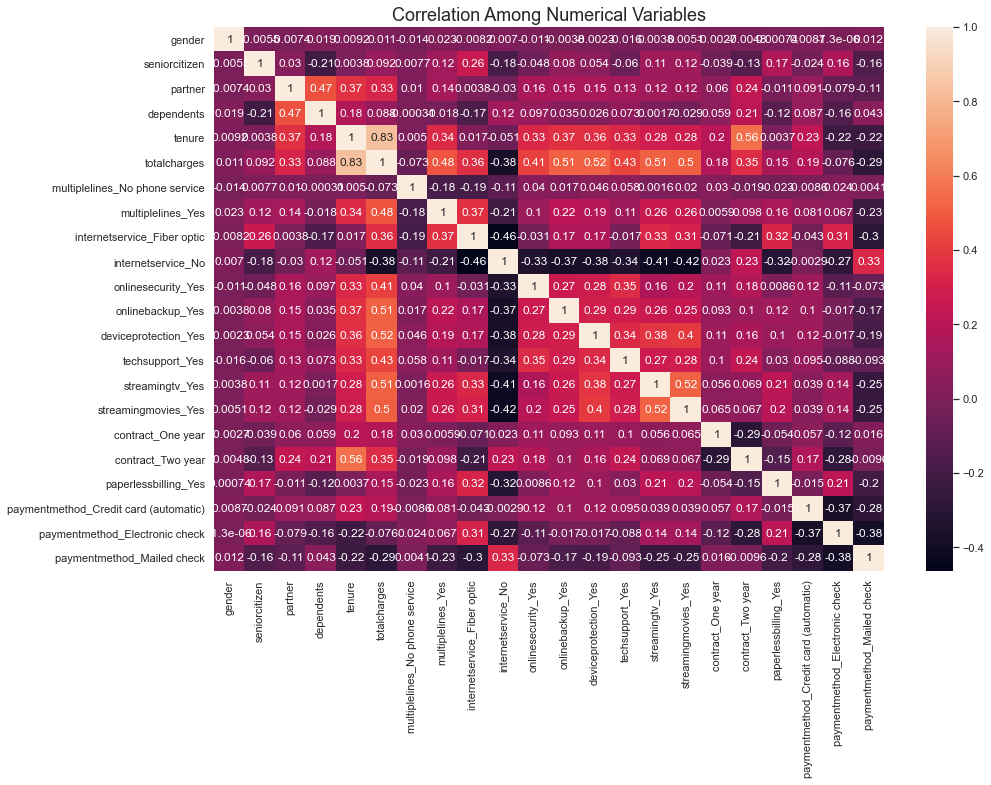

In [61]:
#Inspecting correlation visually
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(X_train.corr(), annot=True)
plt.title('Correlation Among Numerical Variables', fontsize=18);

In [47]:
# Get an idea about how the predictors correlate with the target.

correlation_with_target = X_train.corrwith(y_train)
correlation_with_target.sort_values(ascending=False)



internetservice_Fiber optic              0.320892
paymentmethod_Electronic check           0.290008
monthlycharges                           0.193914
paperlessbilling_Yes                     0.182767
seniorcitizen                            0.146487
streamingmovies_Yes                      0.063203
streamingtv_Yes                          0.053597
multiplelines_Yes                        0.047166
phoneservice                             0.014403
gender                                   0.004288
multiplelines_No phone service          -0.003496
deviceprotection_Yes                    -0.073283
paymentmethod_Mailed check              -0.097015
onlinebackup_Yes                        -0.098296
paymentmethod_Credit card (automatic)   -0.126486
deviceprotection_No internet service    -0.128926
streamingtv_No internet service         -0.128926
streamingmovies_No internet service     -0.128926
onlinesecurity_No internet service      -0.128926
techsupport_No internet service         -0.128926


* ```internetservice_Fiber optic``` has the highest positive correlation with the target variable ```churn```, it is closely followed by ```paymentmethod_Electronic check``` meaning when the churn rate increases these variables increase too.
* On the ```tenure``` and ```contract_Two year``` have the highest negative correlation with the target variable (churn )meaning when these variables increase, the less likely they will churn.


**Investigating correlated independent variables**

In [48]:

#Pairs of highly correlated independent variables
df = X_train.corr().abs().stack().reset_index().sort_values(0, ascending=False)

df['pairs'] = list(zip(df.level_0, df.level_1))

df.set_index(['pairs'], inplace = True)

df.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
df.columns = ['cc']

df.drop_duplicates(inplace=True)

df[(df.cc>.75) & (df.cc<1)]

,cc
pairs,
"(tenure, totalcharges)",0.831428
"(internetservice_Fiber optic, monthlycharges)",0.786959
"(internetservice_No, monthlycharges)",0.760258


* These pairs of independent variable have a high correlation between them which might lead to multicollinearity.Multicollinearity can lead to skewed or misleading results when  attempting to determine how well each independent variable can be used most effectively to predict or understand the dependent variable in a statistical model.<br>
* Inorder to detect and deal with multicollinearity, we'll use Variance Inflation Factor(VIF) to detect it then do a feature selection and drop variables with a high VIF value.


In [49]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                          for i in range(len(X_train.columns))]
vif_data.sort_values(by='VIF',ascending=False).reset_index()

,index,feature,VIF
0,22,streamingmovies_No internet service,inf
1,12,onlinesecurity_No internet service,inf
2,20,streamingtv_No internet service,inf
3,18,techsupport_No internet service,inf
4,16,deviceprotection_No internet service,inf
5,14,onlinebackup_No internet service,inf
6,6,monthlycharges,270.475608
7,5,phoneservice,68.003289
8,7,totalcharges,22.119550
9,10,internetservice_Fiber optic,21.019008


In [50]:
# Drop some variables with high VIF

X_train.drop(['monthlycharges','onlinebackup_No internet service','deviceprotection_No internet service','streamingmovies_No internet service','onlinesecurity_No internet service','streamingtv_No internet service',
'techsupport_No internet service','phoneservice'],axis=1,inplace=True)

In [62]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                          for i in range(len(X_train.columns))]
vif_data.sort_values(by='VIF',ascending=False).reset_index()

,index,feature,VIF
0,5,totalcharges,8.765094
1,4,tenure,7.301794
2,17,contract_Two year,3.392742
3,8,internetservice_Fiber optic,3.346260
4,9,internetservice_No,2.794377
5,2,partner,2.741418
6,15,streamingmovies_Yes,2.725001
7,18,paperlessbilling_Yes,2.719667
8,14,streamingtv_Yes,2.711726
9,20,paymentmethod_Electronic check,2.587672


As noticed above, `tenure` has a high VIF value but it is needed in our analysis since earlier it was noticed it had the highest negative correlation with the target variable `churn`

##### **Scaling train data**

In [51]:
trans =StandardScaler()
X_train[["tenure","totalcharges"]] = trans.fit_transform(X_train[["tenure","totalcharges"]])
X_train[["tenure","totalcharges"]].describe()  # Get statistical summary of the train set

,tenure,totalcharges
count,4.020000e+03,4.020000e+03
mean,-4.949054e-17,-4.330422e-17
std,1.000124e+00,1.000124e+00
min,-1.282839e+00,-1.005702e+00
25%,-9.578112e-01,-8.352813e-01
50%,-1.452417e-01,-3.944274e-01
75%,9.517271e-01,6.916461e-01
max,1.601783e+00,2.782967e+00


##### **Data Balancing using SMOTE**

In [52]:
# Check distribution for the target variable
y_train.value_counts()

0    2945
1    1075
Name: churn, dtype: int64

There is an imbalance in the distribution of the target (churn).

Imbalanced datasets mean that the number of observations differs for the classes in a classification dataset. <br>This imbalance can lead to inaccurate results as the model performance could be having  better scores when actually the scores are mostly representative of the class with the more weight. One good technique to handle this is using SMOTE (Synthetic Minority Over-sampling Technique)

SMOTE, as the name implies augments the minority class by creating synthetic samples.

In [53]:
# Applying SMOTE to the target

smote = SMOTE(random_state=42) # Initialize the ojbect of smote
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train) # Apply the object to our train sets

In [54]:
y_train_resampled.value_counts()  # Validate the balance

1    2945
0    2945
Name: churn, dtype: int64

#### **Preprocessing for the test data**
* Every prepocessing step that was implemented for train will be repeated to the test dataset.

**One hot encoding in X_test**

In [55]:
#Binary encoding
for col in binary_columns:
    X_test[col]=X_test[col].apply(lambda x: 1 if x in ['Yes'] else 0)
X_test.sample(5)

#One hot encode categorical data
for col in non_binary_columns:
    dummies=pd.get_dummies(X_test[col],prefix=col,drop_first=True)
    X_test=X_test.drop(col,axis=1)
    X_test=pd.concat([X_test,dummies],axis=1)
X_test.head(5)

#Binary encoding the gender column
X_test['gender']=X_test['gender'].apply(lambda x: 1 if x in ['Male'] else 0)
X_test.sample(5)
X_test.head(2)


,gender,seniorcitizen,partner,dependents,tenure,phoneservice,monthlycharges,totalcharges,multiplelines_No phone service,multiplelines_Yes,...,streamingtv_No internet service,streamingtv_Yes,streamingmovies_No internet service,streamingmovies_Yes,contract_One year,contract_Two year,paperlessbilling_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
880,1,0,0,0,10,1,110.1,1043.3,0,0,...,0,1,0,1,0,0,1,0,1,0
1903,1,0,1,0,35,1,69.0,2441.7,0,1,...,0,1,0,0,1,0,1,0,1,0


**Labeling the target variable**

In [56]:
# Label the target as 1 or 0
y_test=y_test.apply(lambda x: 1 if x in ['Yes'] else 0)
y_test

880     1
1903    0
2492    1
2296    0
814     0
       ..
1000    1
1843    1
2535    0
1949    0
685     0
Name: churn, Length: 1006, dtype: int64

In [57]:
# First check for the values of the test set for its categorical variables

for category in X_test.columns:
    print(f"The unique values for {category} are {X_test[category].unique()}\n")

The unique values for gender are [1 0]

The unique values for seniorcitizen are [0 1]

The unique values for partner are [0 1]

The unique values for dependents are [0 1]

The unique values for tenure are [10 35 13  1  5 42 69 72  6 60  4 22  2 52 55 51 50  8 12 11 20 26 68  3
 70 39 46 66 40 49 18 56 45 16  9 61 48 14 71 57 53 21 17 24 67 38 62 37
 58 27 30 29 15 34 32 19 43 59 63 33 65 44 28  7 47 23 31 54 64 25 36 41]

The unique values for phoneservice are [1 0]

The unique values for monthlycharges are [110.1   69.    54.45  45.2   20.05  99.    82.45 104.15  55.15  74.1
  61.4   91.    74.4   50.35  80.6   49.45  84.05  99.5   44.85  69.75
  70.35  60.    20.3   89.75  36.05  73.65  19.65  29.8  113.15  54.7
 109.5   74.45  78.85  20.15  20.5   19.45  25.45  24.9  100.8   44.95
  69.4   19.7   95.05 103.75 106.65  93.9   84.   104.75  19.95  35.5
  25.9   44.05  47.4   20.75  20.25  44.2   19.4   83.9   54.15  20.55
  75.3   20.2   56.3   20.4  109.6  103.2   74.3   35.8   19.85 

In [58]:
# Drop same variables as applied to the train set.
# Drop some variables with high VIF

X_test.drop(['monthlycharges','onlinebackup_No internet service','deviceprotection_No internet service','streamingmovies_No internet service','onlinesecurity_No internet service','streamingtv_No internet service',
'techsupport_No internet service','phoneservice'],axis=1,inplace=True)


### **Data standardization of the column**

In [59]:
# perform a robust scaler transform of the dataset
trans =StandardScaler()
X_test[["tenure","totalcharges"]] = trans.fit_transform(X_test[["tenure","totalcharges"]])
X_test[["tenure","totalcharges"]].describe()  # Get statistical summary of the test set



,tenure,totalcharges
count,1.006000e+03,1.006000e+03
mean,1.112430e-16,4.237829e-17
std,1.000497e+00,1.000497e+00
min,-1.319068e+00,-1.007300e+00
25%,-9.453868e-01,-8.033039e-01
50%,-7.346497e-02,-4.165280e-01
75%,8.814971e-01,6.400319e-01
max,1.628859e+00,2.798489e+00


### 4. **Model Training**

For this we shall explore the following algorithms:
* Logistic Regression
* Random Forest
* K- Nearest Neighbour
* Support Vector Machine
* Naive Bayes

#### 4.1.  Logistic Regression

In [67]:
# Training the train sets on logistic regression


logistic_model=LogisticRegression()  # Create an instance of Logistic Regression
logistic_model.fit(X_train_resampled,y_train_resampled)  # Train the train set 
y_predicted_logistic=logistic_model.predict(X_test)  # Validate with the validation set

##### Evaluating our model
**Confusion matrix**

A confusion matrix is a fundamental tool for evaluating the performance of classification models. It provides a more detailed understanding of how well a model is performing by breaking down the predictions into different categories based on the actual and predicted class labels. A confusion matrix is especially useful when dealing with imbalanced classes, multiple classes, or when you want to know more about the types of errors your model is making.

In [68]:
# A function to plot confusion matrix of a model, compute metrics and present them in a dataframe

def evaluate(model, test, predicted):
    """
    Evaluate the performance of a classification model using a combination of visualizing
    a confusion matrix and calculating various performance scores.

    Parameters:
        model (sklearn.base.BaseEstimator): A trained classification model.
        test (array-like): The true labels of the test data.
        predicted (array-like): The predicted labels by the model for the test data.

    Returns:
        pandas.DataFrame: A DataFrame containing various performance scores.

    This function takes a trained classification model, the true labels of the test data,
    and the predicted labels by the model. It first visualizes the confusion matrix to provide
    a graphical representation of the classification results. It then calculates and displays
    various performance scores, including Accuracy, Recall, Precision, F1-Score, and ROC AUC.

    The function uses the scikit-learn's metrics module to calculate the confusion matrix
    and the mentioned performance scores. The confusion matrix is displayed using the
    ConfusionMatrixDisplay class from the sklearn.metrics.plotting module. The function
    returns a DataFrame containing the calculated scores for easy reference and comparison.

    Example:
        # Assuming 'model', 'X_test', and 'y_predicted' are defined
        scores = evaluate(model, y_test, y_predicted)
        print(scores)

    Note:
        - Ensure that the required libraries (sklearn, pandas, matplotlib) are imported before using the function.
        - The 'model' parameter should be a trained classification model that supports the 'classes_' attribute.
    """
    # Calculate the confusion matrix and display it
    cm = metrics.confusion_matrix(test, predicted, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.title(f'Confusion Matrix for {model}')
    plt.grid(False)
    plt.show()

    # Calculate the scores
    scores = {
        'Accuracy': accuracy_score(test, predicted),
        'Recall': recall_score(test, predicted),
        'Precision': precision_score(test, predicted),
        'F1-Score': f1_score(test, predicted),
        'ROC AUC': roc_auc_score(test, predicted)
    }

    # Create a DataFrame from the scores
    scores_df = pd.DataFrame.from_dict(scores, orient='index', columns=['Score'])

    # Display the DataFrame
    
    return scores_df


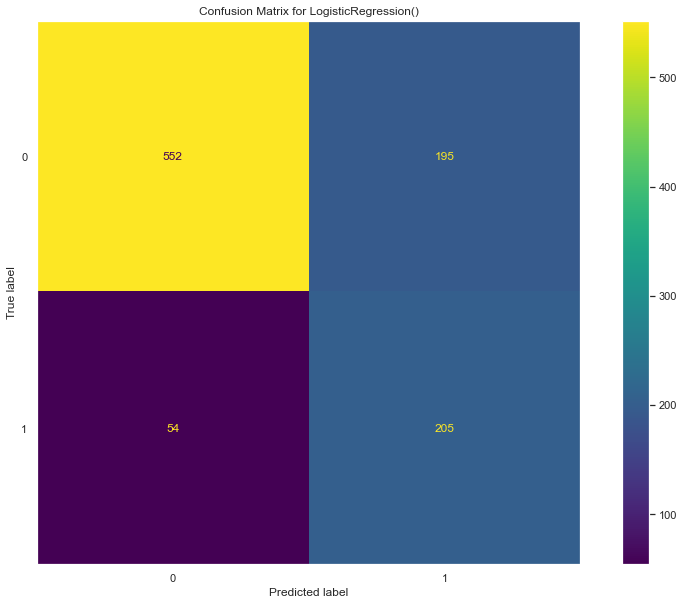

,Score
Accuracy,0.752485
Recall,0.791506
Precision,0.512500
F1-Score,0.622155
ROC AUC,0.765231


In [69]:
# Invoke the evaluate() function on the model trained.
evaluate(logistic_model, y_test, y_predicted_logistic)

From the confusion matrix diagram,:
* The ***True Negatives*** are `552`. This implies that 552 true labes for 0 (churn=false) were acurately predicted out of `747` (665+82).
* The ***False Positives*** are `195`. 195 labels were thus misclassified as positive(1) instead of being negatives (0).
* The ***False Negatives*** are `54`. 54 labels were missclassified as negatives(0) instead of being positives(1).
* The ***True Positves*** are `205`. We accurately predicted 205 positives out of 159 positives which are true.

Check for underfitting or overfitting

In [105]:
#Defining a function that scores the model to check for overfitting or underfitting.


def score(model, x_train, y_train, x_test, y_test):
    """
    Calculate and display the training and testing scores of a given model.

    Parameters:
        model (sklearn.base.BaseEstimator): A trained machine learning model.
        x_train (array-like): The feature matrix of the training data.
        y_train (array-like): The target labels of the training data.
        x_test (array-like): The feature matrix of the testing data.
        y_test (array-like): The target labels of the testing data.

    This function calculates and displays the training and testing scores of a given
    machine learning model. The training score is the accuracy of the model on the
    training data, and the testing score is the accuracy of the model on the testing data.
    
    The function uses the `score` method of the provided model to calculate the accuracy
    on both the training and testing datasets. The scores are then printed to the console
    for easy reference and comparison.

    Example:
        # Assuming 'model', 'X_train', 'y_train', 'X_test', and 'y_test' are defined
        score(model, X_train, y_train, X_test, y_test)

    Note:
        - Ensure that the required libraries (sklearn) are imported before using the function.
    """
    # Calculate training and testing scores
    train_score = model.score(x_train, y_train)
    test_score = model.score(x_test, y_test)
    
    # Print the scores
    print(f"Train score: {train_score:.4f}\nTest score: {test_score:.4f}")

    


In [72]:

# Invoke the function-score() to get train and test scores

score(logistic_model,X_train_resampled,y_train_resampled,X_test,y_test)

Train score: 0.7937
Test score: 0.7525


The train score is `79%` and that of test is `75%`.

Since Both train and test scores exhibited `no` significant differences, <br>
we conclude there is neither underfitting nor overfitting.

#### 4.2 Random Forest

In [73]:
#Instantiate a pipeline
pipeline3=Pipeline([('RF', RandomForestClassifier())])

rf_param_grid = {
    'RF__n_estimators': [10, 30, 100],
    'RF__criterion': ['gini', 'entropy'],
    'RF__max_depth': [None, 2, 6, 10],
    'RF__min_samples_split': [5, 10],
    'RF__min_samples_leaf': [3, 6]
}

rf_grid_search = GridSearchCV(pipeline3, rf_param_grid, cv=3)
rf_grid_search.fit(X_train_resampled, y_train_resampled)

# Print the test and train score
score(rf_grid_search,X_train_resampled, y_train_resampled,X_test,y_test)



Train score: 0.9053
Test score: 0.7674


The model is slighly overfitting since the train score is sligh

In [74]:
#Printing out the best parameters
rf_grid_search.best_params_

{'RF__criterion': 'gini',
 'RF__max_depth': None,
 'RF__min_samples_leaf': 3,
 'RF__min_samples_split': 5,
 'RF__n_estimators': 100}

In [75]:
#Instantiating a rondomForest classifier with the optimal combination of parameters
randomForest=RandomForestClassifier(criterion= 'gini',
 max_depth= None,
 min_samples_leaf= 3,
min_samples_split= 5,
 n_estimators= 100)

randomForest.fit(X_train_resampled, y_train_resampled)


RandomForestClassifier(min_samples_leaf=3, min_samples_split=5)

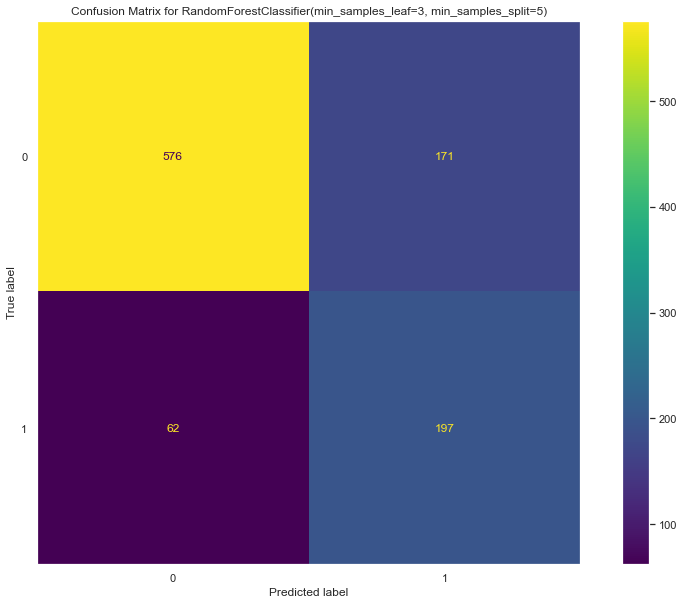

,Score
Accuracy,0.768390
Recall,0.760618
Precision,0.535326
F1-Score,0.628389
ROC AUC,0.765851


In [79]:
y_predicted_rf= randomForest.predict(X_test)
evaluate(randomForest, y_test, y_predicted_rf)

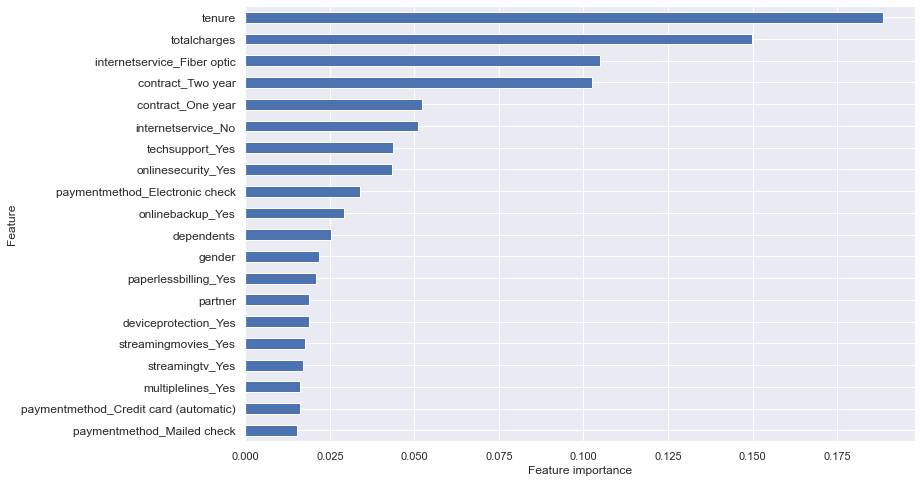

In [84]:
''''def plot_feature_importances(model):
    feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
    feat_importances.nlargest(20)[::-1].plot(kind='barh',figsize=(12,8))
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.yticks(fontsize=12)

plot_feature_importances(randomForest)'''

#### 4.4 KNN 

In [110]:
k_values = [i for i in range (15,30)]
scores = []


for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score_knn= cross_val_score(knn, X_train_resampled, y_train_resampled, cv=5)
    scores.append(np.mean(score_knn))

print(scores)

[0.7921901528013582, 0.7959252971137522, 0.7898132427843805, 0.7962648556876062, 0.7911714770797962, 0.795925297113752, 0.7926994906621392, 0.7972835314091681, 0.7938879456706281, 0.7933786078098471, 0.7899830220713073, 0.7920203735144312, 0.7894736842105263, 0.7903225806451613, 0.7877758913412564]


In [111]:
best_index= np.argmax(scores)
best_k= k_values[best_index]
best_k

22

In [112]:
# instantiate the KNN model 
knn_baseline_model = KNeighborsClassifier(n_neighbors=best_k)

# fit the model on X_train_resampled, y_train_resampled
knn_baseline_model.fit(X_train_resampled, y_train_resampled)



KNeighborsClassifier(n_neighbors=22)

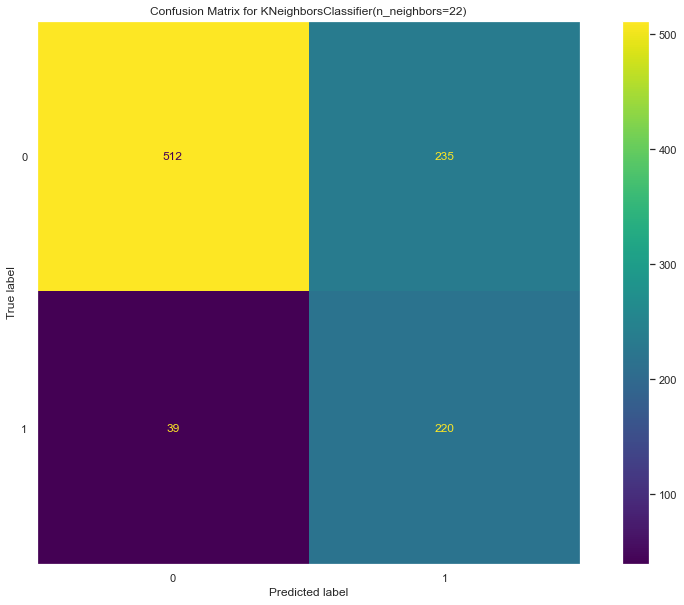

,Score
Accuracy,0.727634
Recall,0.849421
Precision,0.483516
F1-Score,0.616246
ROC AUC,0.767415


In [113]:
y_predicted_knn= knn_baseline_model.predict(X_test)
evaluate(knn_baseline_model, y_test, y_predicted_knn)

In [114]:
# Print the test and train score
score(knn_baseline_model,X_train_resampled, y_train_resampled,X_test,y_test)

Train score: 0.8090
Test score: 0.7276


#### Support Vector Machine

In [117]:
svm_model = svm.SVC(kernel="linear").fit(X_train_resampled,y_train_resampled)

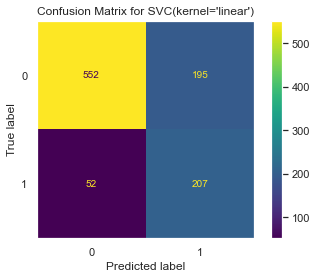

,Score
Accuracy,0.754473
Recall,0.799228
Precision,0.514925
F1-Score,0.626324
ROC AUC,0.769092


In [118]:
y_predicted_svm= svm_model.predict(X_test)
evaluate(svm_model, y_test, y_predicted_svm)

In [119]:
score(svm_model,X_train_resampled, y_train_resampled,X_test,y_test)

Train score: 0.7878
Test score: 0.7545


### 4.5 XG Boost

In [122]:
XG = XGBClassifier()
XG.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

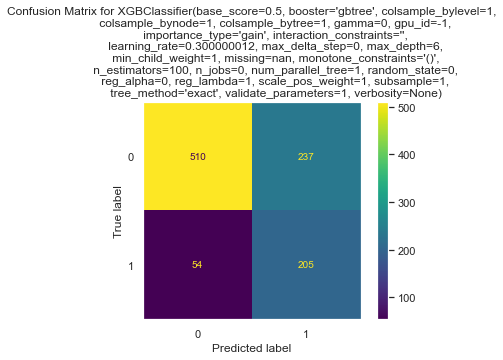

In [124]:
y_predicted_xgb= XG.predict(X_test)
evaluate(XG, y_test, y_predicted_xgb);

In [125]:
score(XG,X_train_resampled, y_train_resampled,X_test,y_test)

Train score: 0.9482
Test score: 0.7107
